# Homework 4 
## Predicting the Poverty of Costa Ricans

many thanks to the people and kernals I consulted. 

- https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough
- https://www.kaggle.com/youhanlee/3250feats-532-feats-using-shap-lb-0-436

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy
#import modules that describe distributions
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
#turn off warnings for sns depreciated versions- this is the best
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [18]:
df = pd.read_csv(r"C:\Users\zgeorge\Dropbox (CMN Hospitals)\George\School\Fall 2018\Applied Machine Learning\AML_code\Homework 4\Data\train.csv")
ID = df['Id']
Target = df['Target']
#drop ID now, and we'll drop target after the correlation tests
df = df.drop(['Id'],axis=1)
df.head(5)

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,190000.0,0,3,0,1,1,0,NaN,0,1,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,NaN,0,8,0,1,1,0,NaN,0,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## Cleaning Data
### Correct Data Types

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 142 entries, v2a1 to Target
dtypes: float64(8), int64(130), object(4)
memory usage: 10.4+ MB


In [20]:
#fix the variables that should be categorical
df[['dependency','edjefa','edjefe',]] = df[['dependency','edjefa','edjefe',]].astype('category')
#fix the variables that should be Bool
#df[['']] = df[['']].astype('bool')
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 142 entries, v2a1 to Target
dtypes: category(3), float64(8), int64(130), object(1)
memory usage: 10.2+ MB


### Removing Nulls

In [21]:
#because when categorical data has n/a's in many cases that is just another category. However the numerical should not have n/a's
numeric_train=df.select_dtypes(include=[np.number])
#create NA's count variable
nas = numeric_train.isnull().sum().sort_values(ascending=False)
#create percent variable
percent = 100*(numeric_train.isnull().sum()/numeric_train.isnull().count()).sort_values(ascending=False)
#combine lists
nasnum_train = pd.concat([nas, percent],axis=1,keys=['NAs','Percent'])
nasnum_train.head(5)

,NAs,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
meaneduc,5,0.052318
SQBmeaned,5,0.052318


In [22]:
#dropping rez_esc for now, hopefully we can come back to reclaim this variable
df = df.drop(['rez_esc'],axis=1)

In [23]:
#v18q1 is the number of tablets, fill in with zeros
df['v18q1'] = df['v18q1'].fillna(0)

In [24]:
#give them the median education for their age for mean educ
df['meaneduc'] = df.apply(
    lambda row: row['edjefe'] if np.isnan(row['meaneduc']) else row['meaneduc'],
    axis=1
)

In [25]:
df['meaneduc'] = df.apply(
    lambda row: row['edjefa'] if row['meaneduc']=='no' else row['meaneduc'],
    axis=1
)
df[['meaneduc']] = df[['meaneduc']].astype('int32')
df['SQBmeaned'] = df['meaneduc']**2

In [26]:
#for v2a1, because there are so few people renting, we will drop that for now
df = df.drop('v2a1',axis=1)

In [27]:
#because when categorical data has n/a's in many cases that is just another category. However the numerical should not have n/a's
numeric_train=df.select_dtypes(include=[np.number])
#create NA's count variable
nas = numeric_train.isnull().sum().sort_values(ascending=False)
#create percent variable
percent = 100*(numeric_train.isnull().sum()/numeric_train.isnull().count()).sort_values(ascending=False)
#combine lists
nasnum_train = pd.concat([nas, percent],axis=1,keys=['NAs','Percent'])
nasnum_train.head(5)

,NAs,Percent
Target,0,0.0
public,0,0.0
sanitario3,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0


In [28]:
#because when categorical data has n/a's in many cases that is just another category. However the numerical should not have n/a's
cat_train=df.select_dtypes(exclude=[np.number])
#create NA's count variable
nas = cat_train.isnull().sum().sort_values(ascending=False)
#create percent variable
percent = 100*(cat_train.isnull().sum()/cat_train.isnull().count()).sort_values(ascending=False)
#combine lists
nascat_train = pd.concat([nas, percent],axis=1,keys=['NAs','Percent'])
nascat_train.head(5)

,NAs,Percent
edjefa,0,0.0
edjefe,0,0.0
dependency,0,0.0
idhogar,0,0.0


In [29]:
def replace_edjefx(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
df['edjefe'] = df['edjefe'].apply(replace_edjefx).astype(float)
df['edjefa'] = df['edjefa'].apply(replace_edjefx).astype(float)

### Checking for covariance

In [30]:
#Create a list that displays only numeric variables
numeric_var=df.select_dtypes(include=[np.number]).columns
#Here we set up our correlation matrix for numeric variables
correlation=df[numeric_var].corr()
#Pull the max (whether positive or negative) correlation of each variable to another variable
aux=(abs(correlation)-np.identity(correlation.shape[0])).max()
aux.sort_index

<bound method Series.sort_index of hacdor             0.794699
rooms              0.804070
hacapo             0.652594
v14a               0.532663
refrig             0.223078
v18q               0.849916
v18q1              0.849916
r4h1               0.758136
r4h2               0.821367
r4h3               0.821367
r4m1               0.767461
r4m2               0.820109
r4m3               0.820109
r4t1               0.782178
r4t2               0.806381
r4t3               0.998107
tamhog             1.000000
tamviv             0.945243
escolari           0.943325
hhsize             1.000000
paredblolad        0.582085
paredzocalo        0.351198
paredpreb          0.582085
pareddes           0.434230
paredmad           0.451195
paredzinc          0.303911
paredfibras        0.252625
paredother         0.173487
pisomoscer         0.804205
pisocemento        0.804205
                     ...   
bedrooms           0.804070
overcrowding       0.945094
tipovivi1          0.599882
tipovivi2    

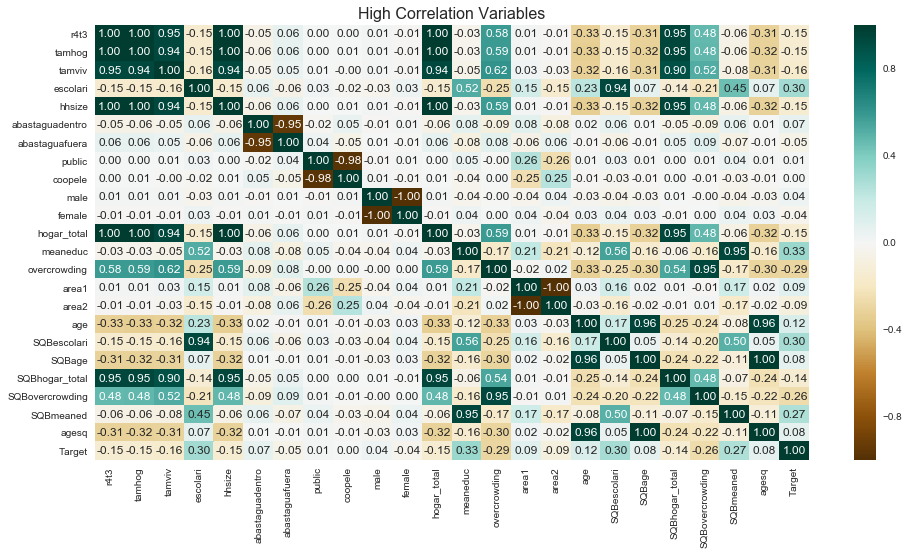

In [34]:
#Throw out any variables that don't have at least .7 correlation with something else
selected_feats=aux[(aux>0.94) | ((aux>.328198) & (aux<.3282))].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
#make the plot have numbers, a legend and pretty colors
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax,cmap="BrBG",center=0)
plt.title('High Correlation Variables',fontsize=16)
#show the plot
plt.show()

 - r4t3 & tamhog & hhsize & hogar_total: keep hhsize for sake of var name
 - public and coopele: keeping public as there is a slight correlation
 - area1 & area2: getting rid of area 2 as you have to be one or the other

### Feature Engineering